In [1]:
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.


In [2]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [4]:


os.listdir(path)


['chest_xray']

In [5]:
transform =transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])

])

In [6]:
train_data = datasets.ImageFolder(
    root=os.path.join(path, "chest_xray", "train"),
    transform=transform
)

val_data = datasets.ImageFolder(
    root=os.path.join(path, "chest_xray", "val"),
    transform=transform
)


In [7]:
train_loader = DataLoader(train_data , batch_size=32 , shuffle = True)
val_Loader = DataLoader(val_data , batch_size=32 , shuffle=True)

train_data.classes

['NORMAL', 'PNEUMONIA']

In [8]:
class LungCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(1,32, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32,64, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
  def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [9]:
model = LungCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss:.4f}")


Epoch [1/10] Loss: 38.6278
Epoch [2/10] Loss: 13.3022
Epoch [3/10] Loss: 9.1266
Epoch [4/10] Loss: 6.1829
Epoch [5/10] Loss: 4.8822
Epoch [6/10] Loss: 4.6368
Epoch [7/10] Loss: 1.7204
Epoch [8/10] Loss: 3.0789
Epoch [9/10] Loss: 1.2956
Epoch [10/10] Loss: 0.3692


In [14]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_Loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

torch.save(model.state_dict(), "lung_cnn_model.pth")
print("Model saved to lung_cnn_model.pth")

Validation Accuracy: 93.75%
Model saved to lung_cnn_model.pth


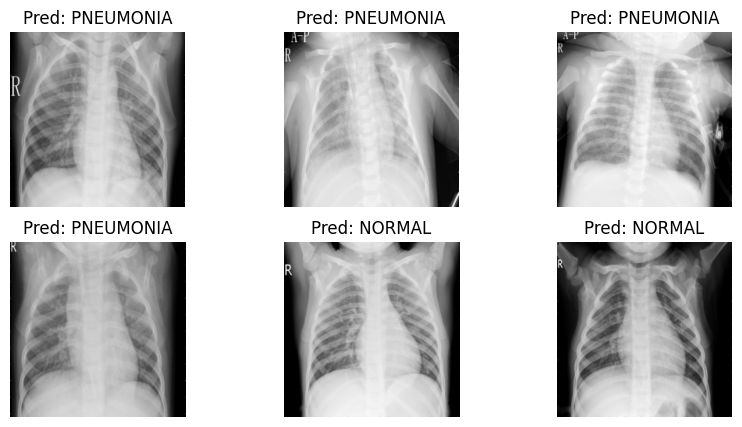

In [12]:
images, labels = next(iter(val_Loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title(f"Pred: {train_data.classes[preds[i]]}")
    plt.axis("off")
plt.show()


In [15]:
from google.colab import files
files.download("lung_cnn_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>